In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurements = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Inspection of Classes

In [9]:
#  Connect Inspector to engine
inspector = inspect(engine)

In [10]:
# Get Columns from Measurements
meas_columns = inspector.get_columns('measurement')
for column in meas_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get columns from the Station Table
stat_columns = inspector.get_columns('station')
for column in stat_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent = session.query(Measurements.date).order_by(Measurements.date.desc()).first()[0]

# Covert date text to date time
query_date = datetime.strptime(most_recent,'%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores

weather_data = session.query(Measurements.date, Measurements.prcp).\
filter(Measurements.date >= query_date - dt.timedelta(days=365)).\
order_by(Measurements.date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
weather_data_df = pd.DataFrame(weather_data)


# Sort the dataframe by date
weather_data_final_df = weather_data_df.set_index('date')
weather_data_final_df.sample(15)



,prcp
date,
2016-10-13,0.00
2016-09-07,0.05
2016-10-17,0.03
2016-11-23,0.03
2017-05-07,0.00
2016-12-08,0.03
2017-02-06,0.04
2016-11-11,0.00
2016-12-07,0.12


<function matplotlib.pyplot.show(close=None, block=None)>

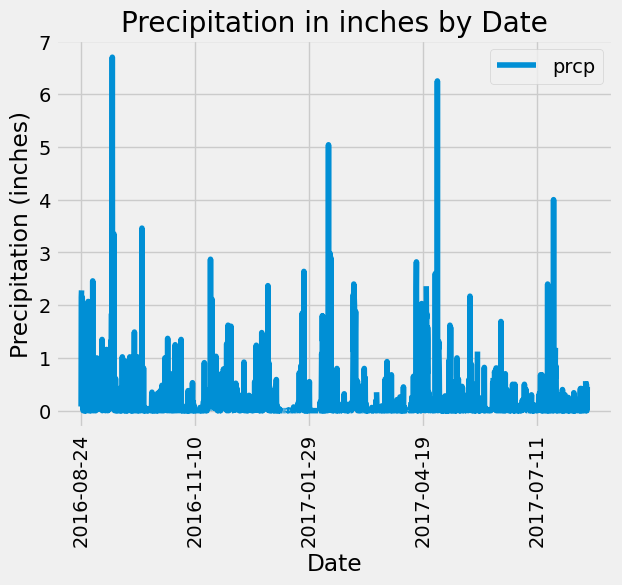

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
weather_data_final_df.plot()
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=90)
plt.title('Precipitation in inches by Date')
plt.show

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
weather_data_final_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(func.distinct(Measurements.station))).first()[0]
total_stations

9

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurements.station, func.count(Measurements.id)).\
group_by(Measurements.station).\
order_by(func.count(Measurements.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

# The station id has the greatest number of observations is USC005519281 with 2772 observations.

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


sel = (Measurements.station
    , func.min(Measurements.tobs)
    , func.max(Measurements.tobs)
    , func.round(func.avg(Measurements.tobs),1)
   )

station_stats = session.query(*sel).filter(Measurements.station == active_stations[0][0]).all()
for temps in station_stats:
    print(station_stats)

[('USC00519281', 54.0, 85.0, 71.7)]


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_station = session.query(Measurements.station, Measurements.tobs).\
filter(Measurements.date >= query_date - dt.timedelta(days=365)).\
filter(Measurements.station == 'USC00519281').all()
tobs_station

# Save the query results as a Pandas DataFrame and set the index 
tobs_station_df = pd.DataFrame(tobs_station, columns=['Measurement Date', 'Temperature'])
final_station_df = tobs_station_df.set_index('Measurement Date')
final_station_df.sample(10)

,Temperature
Measurement Date,
USC00519281,75.0
USC00519281,74.0
USC00519281,73.0
USC00519281,78.0
USC00519281,73.0
USC00519281,78.0
USC00519281,71.0
USC00519281,69.0
USC00519281,71.0


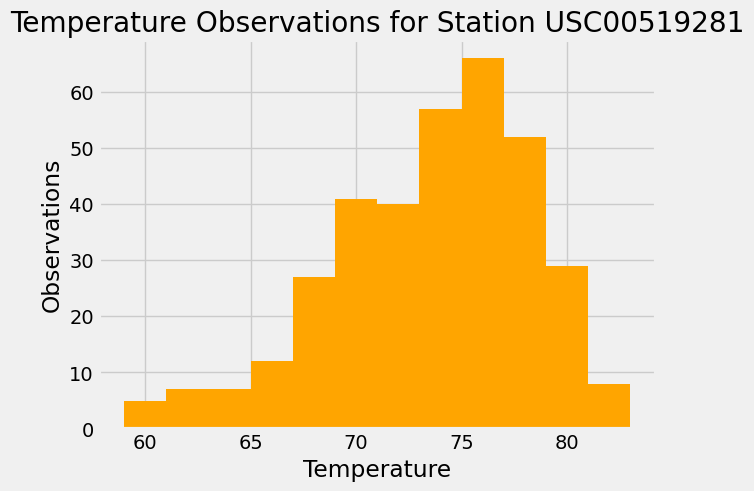

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.hist(final_station_df, bins=12, color='orange')
plt.xlabel('Temperature')
plt.ylabel('Observations')
plt.title('Temperature Observations for Station USC00519281')
plt.show()

# Close session

In [21]:
# Close Session
session.close()